In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2
import torch.nn as nn
import torch

#img1 = cv2.imread('donald-trump-1.jpg')
#img2 = cv2.imread('donald-trump-2.jpg')

#data  cis.upenn.edu/~cis580/Spring2015/Projects/proj2/SfMProjectData.zip

img1 = cv2.imread('image0000001.bmp')
img2 = cv2.imread('image0000002.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)

plt.imshow(img3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
print(dir(matches[0]))
print(matches[0].trainIdx)
print(matches[0].queryIdx)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
395
371


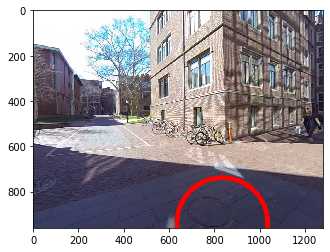

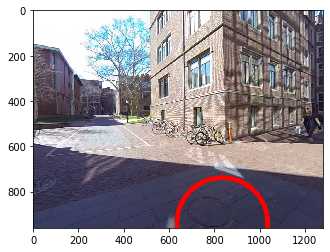

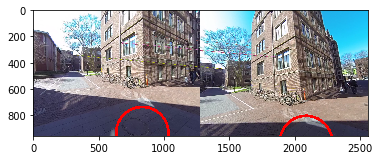

[[1194.3939     17.418243]]
[[369.10086 379.46884]]


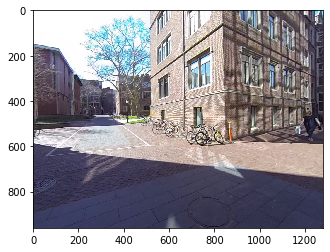

In [3]:
imageA = img1.copy()
imageB = img2.copy()
imageA = cv2.circle(imageA , (835, 938), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
imageB = cv2.circle(imageB , (806, 1006), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
img4 = cv2.drawMatches(imageA, kp1, imageB, kp2, matches[:10], None, flags=2)
plt.imshow(img4)
plt.show()
print(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]))
print(cv2.KeyPoint_convert([kp2[matches[0].queryIdx]]))

plt.imshow(img1)
plt.show()

In [4]:
import random
import scipy.linalg

#Normalized 8-point algorithm

class LinearLeastSquaresModel():
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.

    """

    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device    
        self.MSE = nn.MSELoss(reduction='none')
        #value will be assigned after calling fit
        self.x = None
        
    def fit(self, data, T1, T2):
        _, _, Vh = scipy.linalg.svd(data)
        #(Hermitian) transpose back
        x = Vh.transpose()[:, -1];
        U, D, Vh = scipy.linalg.svd(x.reshape((3, 3)))
        F = U @ np.diag(np.array([D[1], D[2], 0])) @ Vh
        F = T2.transpose() @ F @ T1
        self.x = torch.tensor(F).view(9).to(self.device);
        return F
    
    def calc_err(self, data):
        batch_size = data.shape[0]
        compute_result = (data @ self.x)
        err = self.MSE(compute_result, torch.zeros((batch_size), dtype=torch.float64).to(self.device))
        return err

def EstimateFundamentalMatrix(sample_points, T1, T2, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    LSmodel = LinearLeastSquaresModel(device = device)
    F = LSmodel.fit(np.array(sample_points), T1, T2)
 
    return F, LSmodel    
    


def convert2Homogeneous(a):
    temp = np.zeros((3,len(a)))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        temp[0][i] = x1
        temp[1][i] = y1
        temp[2][i] = 1
    return temp

def normalise2dpts(pts):
    """
    based on http://pydoc.net/ippe/0.0.1/ippe.homo2d/
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
    if len(finiteind) != pts.shape[1]:
        print('WARNING(normalise2dpts): Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)
    return [newpts, T]

def transform(a,b):
    #####
    #input shape: [batch, [x, y, 1]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

    
def RANSAC(trainPoints, queryPoints, max_iter_times = 1000000, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    t = time.time()
    x1, T1 = normalise2dpts(convert2Homogeneous(trainPoints))
    x2, T2 = normalise2dpts(convert2Homogeneous(queryPoints))
    data = transform(x1.transpose(), x2.transpose())
    
    iterations = 0
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    
    batch_size = batches.shape[0]
    
    episilon = batches.new_full((1, batch_size), 0.01).view(batch_size).to(device)
    train_inliers = []
    query_inliers = []
    
    while iterations < max_iter_times:

        sample_points = random.sample(data, 8)
        F, LSmodel = EstimateFundamentalMatrix(sample_points, T1, T2, device)
        err = LSmodel.calc_err(batches)
        if((err < episilon).float().mean().item() > 0.95):           
            ind = np.where((err.cpu()<episilon.cpu()))
            train_inliers = trainPoints[ind]
            query_inliers = queryPoints[ind]
            break
        iterations += 1
        
    print('[RANSAC] takes ', time.time() - t,'sec')
    print('[RANSAC] iteration', iterations,' err:', err.mean().item())     
    if(iterations == max_iter_times):
        print("no result found by RANSAC")
    
    return F, train_inliers, query_inliers, ind

In [5]:
trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
F, train_inliers, query_inliers, ind = RANSAC(trainPoints, queryPoints, max_iter_times = 1000000)
print('F',F)
F, mask = cv2.findFundamentalMat(trainPoints,queryPoints,cv2.FM_LMEDS)
print('opencv_F',F)

WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.02736639976501465 sec
[RANSAC] iteration 3  err: 0.003639029783622952
F [[-8.90462313e-07  3.08308929e-06 -3.27639382e-04]
 [ 1.04956395e-06 -2.37243180e-06  5.50117203e-05]
 [-1.12137488e-04  1.29603633e-06  6.03231617e-02]]
opencv_F [[-5.03773825e-07 -1.04895552e-07  3.68371907e-04]
 [ 2.25260921e-06  2.05999542e-06 -2.39201885e-03]
 [-7.46550999e-04 -1.12537940e-03  1.00000000e+00]]


In [6]:
print(np.array(train_inliers).shape)


(178, 2)


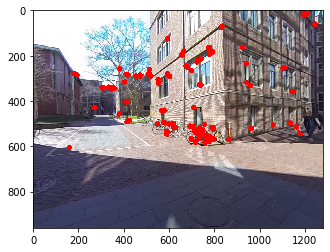

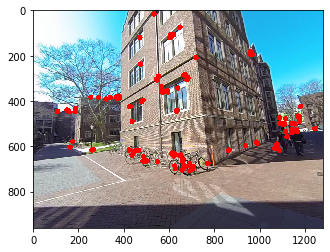

In [7]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageB)
plt.show()


In [8]:
f1 = 568.996140852
f2 = 568.988362396
s = 0
mx = my = 1
px = 643.21055941
py = 477.982801038
K = np.array([[f1*mx, s, px],[0, f2*my, py], [0, 0, 1]])
E = K.transpose() @ F @ K

In [9]:
print('Fundamental Matrix:',F)
print('Camera intrinsic Matrix:',K)
print('Essential Matrix:',E)

Fundamental Matrix: [[-5.03773825e-07 -1.04895552e-07  3.68371907e-04]
 [ 2.25260921e-06  2.05999542e-06 -2.39201885e-03]
 [-7.46550999e-04 -1.12537940e-03  1.00000000e+00]]
Camera intrinsic Matrix: [[568.99614085   0.         643.21055941]
 [  0.         568.9883624  477.98280104]
 [  0.           0.           1.        ]]
Essential Matrix: [[-0.16310011 -0.03396016 -0.00329961]
 [ 0.72928715  0.66691889  0.02362756]
 [ 0.003485   -0.11846733 -0.00198296]]


In [10]:
U, D, Vh = scipy.linalg.svd(E)
print('U:',U)
print('D:',D)
print('Vh:',Vh)
W = np.array([[0, -1, 0],[1, 0 ,0], [0, 0, 1]])
print('W',W)
eps = 1e-5
def CameraPosition1Config():
    R1 = U @ W @ Vh
    C1 = U[:,2]
    det = np.linalg.det(R1)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C1 = -C1
        R1 = -R1 
    return C1, R1

def CameraPosition2Config():
    R2 = U @ W @ Vh
    C2 = -U[:,2]
    det = np.linalg.det(R2)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C2 = -C2
        R2 = -R2    
    return C2, R2

def CameraPosition3Config():
    R3 = U @ W.transpose() @ Vh
    C3 = U[:,2]
    det = np.linalg.det(R3)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C3 = -C3
        R3 = -R3
    return C3, R3    
        
def CameraPosition4Config():
    R4 = U @ W.transpose() @ Vh
    C4 = -U[:,2]
    det = np.linalg.det(R4)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C4 = -C4
        R4 = -R4
    return C4, R4

U: [[-0.14349556 -0.68202768  0.71711036]
 [ 0.98666803 -0.04237576  0.15713208]
 [-0.07678033  0.73009763  0.67901564]]
D: [1.00187680e+00 1.23523685e-01 9.76108716e-10]
Vh: [[ 0.74130959  0.6707378   0.02389345]
 [ 0.67095697 -0.74149455 -0.00160749]
 [-0.01663866 -0.01722312  0.99971322]]
W [[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]


In [11]:
def CameraPoseMatrix(K, R, C):
    return K @ R @ np.array([[1,0,0, -C[0]],[0,1,0, -C[1]],[0,0,1, -C[2]]])

In [12]:
#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])
P1 = CameraPoseMatrix(K, R0, C0)#K @ R0 @ np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])


#second camera
C1, R1 = CameraPosition1Config()
C2, R2 = CameraPosition2Config()
C3, R3 = CameraPosition3Config()
C4, R4 = CameraPosition4Config()
E = U @ np.array([[1,0,0],[0,1,0],[0,0,0]]) @ Vh
P2 = CameraPoseMatrix(K, R1, C1) #np.concatenate((R1, -C1.reshape(3,1)), axis=1)
print('P1:', P1)
print('P2:', P2)
print('R1:', R1)
print('C1:', C1)

P1: [[568.99614085   0.         643.21055941   0.        ]
 [  0.         568.9883624  477.98280104   0.        ]
 [  0.           0.           1.           0.        ]]
P2: [[-1.34305313e+02  5.70221870e+01 -8.46278314e+02 -6.61987926e+02]
 [ 1.18117004e+02 -5.99832377e+02 -4.22450953e+02 -2.96400786e+02]
 [-5.81446759e-01 -4.21077111e-01 -6.96142035e-01 -9.55817547e-01]]
R1: [[ 0.42124606  0.5762138  -0.70037805]
 [ 0.69603981 -0.70047963 -0.15766058]
 [-0.58144676 -0.42107711 -0.69614204]]
C1: [-0.71711036 -0.15713208 -0.67901564]


In [13]:
from numpy.linalg import inv
print(C1)
print(R1)
print(img1.shape)

[-0.71711036 -0.15713208 -0.67901564]
[[ 0.42124606  0.5762138  -0.70037805]
 [ 0.69603981 -0.70047963 -0.15766058]
 [-0.58144676 -0.42107711 -0.69614204]]
(960, 1280, 3)


In [14]:
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear

def LinearTriangulation(v1, v2, P1, P2):
    row1 = v1[0]*P1[2,:] - P1[1,:]
    row2 = v1[1]*P1[2,:] - P1[0,:]
    row3 = v2[0]*P2[2,:] - P2[1,:]
    row4 = v2[1]*P2[2,:] - P2[0,:]
    #row5 = np.array([1,1,1,1])
    A = np.array([row1,row2,row3,row4])
    b = np.array([0,0,0,0])
    res = lsq_linear(A, b, bounds=([-1000,-1000,-1000,1], [1000,1000,1000,1.0001]),lsmr_tol='auto')
    return res.x

In [15]:
def getWorldPoints(train_inliers, query_inliers, P1, P2):
    points = []
    for (train_inlier, query_inlier) in zip(train_inliers, query_inliers):
        points.append(LinearTriangulation(train_inlier, query_inlier, P1, P2))
    return np.array(points)

In [16]:
points = getWorldPoints(train_inliers, query_inliers, P1, P2)


In [17]:
print(points[:10])

[[ 0.10928738  0.08574437 -0.12022697  1.        ]
 [ 0.25229954  0.54987233 -0.73806429  1.        ]
 [-0.69796556  0.55688326  0.22385797  1.        ]
 [ 0.05673793  0.12933869 -0.21010146  1.        ]
 [ 0.05933101  0.00943596 -0.13772732  1.        ]
 [-0.05624679  0.22274332 -0.48100609  1.        ]
 [-0.45784377  0.12514245 -0.32020953  1.        ]
 [-0.03186055  0.19045203 -0.24681483  1.        ]
 [-0.48968542  0.1340557  -0.26417853  1.        ]
 [-0.0292621   0.15274072  0.07974175  1.        ]]


In [18]:
print(len(points))

178


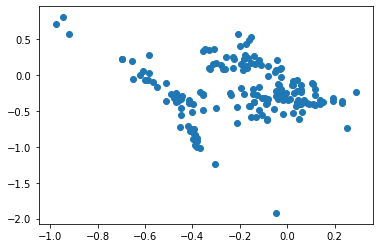

In [19]:
import matplotlib.pyplot as plt
#XZ
plt.scatter(points[:,0], points[:,2])
plt.show()


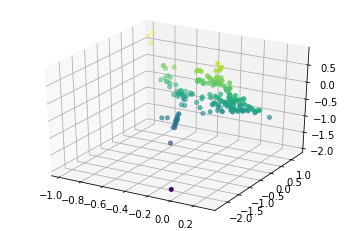

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);

In [21]:
# def sift_feature(image, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
#     print("image shape:",image.shape, )
#     h,w = image.shape
#     patch_size = min([h,w])
#     patch = image[:patch_size, :patch_size]#image[h//4: h//4 + patch_size,w//3 : w//3 + patch_size]
#     # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
#     patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
#     patches[0,0,:,:] = patch
        
#     SIFT = SIFTNet(patch_size = patch_size).to(device)
#     SIFT.eval()
    
#     t = time.time()
#     with torch.no_grad():       
#         torch_patches = torch.from_numpy(patches).cuda()
#         res = SIFT(torch_patches)
#         print(res)
#         sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)

#     print ('device:',device)
#     print(' time', time.time() - t)   
#     plt.figure()
#     plt.imshow(patch, cmap="gray")
#     return sift

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
import glob, os
from mpl_toolkits import mplot3d

from Normalized8pointsAlgo import RANSAC
from CameraConfig import *
from Triangulation import *


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r,c,_) = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


def TwoImage(img1_name, img2_name, C0, R0):
    img1 = cv2.imread(img1_name)
    img2 = cv2.imread(img2_name)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    #Oriented FAST and Rotated BRIEF
    orb = cv2.ORB_create(edgeThreshold=3)

    # find the keypoints with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    #img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

    #plt.imshow(img3)
    #plt.show()

    trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
    queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
    pts1 = np.int32(trainPoints)
    pts2 = np.int32(queryPoints)
    
    my_F, train_inliers, query_inliers, ind = RANSAC(pts1, pts2, max_iter_times = 1000000) 
    
#     # Find epilines corresponding to points in right image (second image) and
#     # drawing its lines on left image
#     lines1 = cv2.computeCorrespondEpilines(query_inliers.reshape(-1,1,2), 2, my_F)
#     lines1 = lines1.reshape(-1,3)
#     img5,img6 = drawlines(img1.copy(),img2.copy(),lines1,train_inliers,query_inliers)
#     # Find epilines corresponding to points in left image (first image) and
#     # drawing its lines on right image
#     lines2 = cv2.computeCorrespondEpilines(train_inliers.reshape(-1,1,2), 1, my_F)
#     lines2 = lines2.reshape(-1,3)
#     img3,img4 = drawlines(img2.copy(),img1.copy(),lines2,query_inliers,train_inliers)
# #     print("my Fundamental matrix")
#     plt.imshow(img5)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
    
#     imageA = img1.copy()
#     imageB = img2.copy()
#     for i in train_inliers:
#         imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
#     plt.imshow(imageA)
#     plt.show()
#     for i in query_inliers:
#         imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
#     print("my inliers")
#     plt.imshow(imageB)
#     plt.show()
    
#     print('my F results')

    E = getEssentialMatrix(my_F)
    U, D, Vh = getEssentialConfig(E)

    #second camera
    C1, R1 = CameraPosition1Config(U, D, Vh)
    C2, R2 = CameraPosition2Config(U, D, Vh)
    C3, R3 = CameraPosition3Config(U, D, Vh)
    C4, R4 = CameraPosition4Config(U, D, Vh)
    Cs = [C1,C2,C3,C4]
    Rs = [R1,R2,R3,R4]

    best_ct = 0
    best_secondCamera_C = None
    best_secondCamera_R = None
    points = None

    for C,R in zip(Cs, Rs):
        P1, P2 = getCameraMatrix(U, Vh, K, R0, C0, R, C) 
        temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
        n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
        if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
            best_ct = n_in_front_of_C1 + n_in_front_of_C2
            best_secondCamera_C = C
            best_secondCamera_R = R
            points = temp_points
    #print("max points in front of both cameras:", best_ct)
    print("len(points):",len(points))
    #XZ
#     plt.scatter(points[:,0], points[:,2])
#     plt.scatter(C0[0], C0[2], c='red')
#     plt.scatter(C1[0], C1[2], c='black')
#     plt.show()
#     ax = plt.axes(projection='3d')
#     ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
#     ax.scatter(C0[0], C0[1], C0[2], c='red', linewidth=15);
#     ax.scatter(C1[0], C1[1], C1[2], c='black', linewidth=15);
#     plt.show()
    return best_secondCamera_C, best_secondCamera_R, K.astype(np.float64), train_inliers.astype(np.float64), query_inliers.astype(np.float64), points.astype(np.float64)
    
if __name__== "__main__":
    files = []
    for file in glob.glob("*.bmp"):
        print(file)
        files.append(file)
    camera_params = []
    camera_indices = []
    points_3d = []
    points_2d = []
    
    #first camera
    C0 = np.array([0,0,0])
    R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    C = {}
    R = {}
    C[0] = C0
    R[0] = R0
    
    #table = []
    
    for img1_ct,img1 in enumerate(files):
        for img2_ct,img2 in enumerate(files):
            if img1 != img2 and img1_ct < img2_ct:
                print(img1_ct, img2_ct, img1, img2)
                dist_coef = np.zeros((4,1))
                outC, outR, K, train_inliers, query_inliers, points3D = TwoImage(img1,img2, C[img1_ct], R[img1_ct])
                if img1_ct == 0:
                    C[img2_ct] = outC
                    R[img2_ct] = outR
                print(len(train_inliers))
                print(len(points3D))
                try:
                    (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], train_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
                except:
                    if(img1_ct==0):
                        raise
                    else:
                        continue
                camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
                for i in range(len(points3D)):
                    points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                    camera_indices.append(img1_ct)
                    
                for i in range(len(train_inliers)):
                    points_2d.append(train_inliers[i]) 
                
                
                try:
                    (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], query_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
                except:
                    continue
                camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
                for i in range(len(points3D)):
                    points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                    camera_indices.append(img2_ct)
                for i in range(len(query_inliers)):
                    points_2d.append(query_inliers[i])
                
                #table.append({str(img1_ct)+"to"+str(img2_ct):[rvec,tvec]})
                #solvePnP(InputArray objectPoints, InputArray imagePoints, InputArray cameraMatrix, InputArray distCoeffs, OutputArray rvec, OutputArray tvec, bool useExtrinsicGuess=false, int flags=ITERATIVE )¶

image0000005.bmp
image0000006.bmp
image0000004.bmp
image0000002.bmp
image0000001.bmp
image0000003.bmp
0 1 image0000005.bmp image0000006.bmp
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.024035930633544922 sec
[RANSAC] iteration 99  err: 1.1859711165187841e-07
[[ 687  318]
 [ 815  633]
 [ 512  597]
 [ 930  702]
 [ 484  465]
 [ 814  640]
 [ 842  228]
 [ 737  636]
 [1136  547]
 [ 184  365]
 [ 792  642]
 [1254  566]
 [1138  527]
 [ 507  599]
 [ 831  293]
 [ 257  580]
 [ 381  349]
 [ 770  415]
 [ 132  386]
 [ 516  609]
 [ 505  599]
 [ 145  391]
 [ 839  230]
 [ 489  459]
 [ 694  427]
 [  92  385]
 [ 900  640]
 [ 757   25]
 [1238  489]
 [1173  537]
 [ 755  310]
 [ 788  646]
 [ 139  388]
 [ 844  227]
 [ 557  639]
 [ 846  257]
 [ 680  308]
 [  93  352]
 [ 809  716]
 [ 924  660]
 [ 381  349]
 [ 485  463]
 [ 689  319]
 [ 142  387]
 [ 504  599]
 [ 883  734]
 [1201  569]
 [1135  547]
 [1194  535]
 [ 711  323]
 [1134  537]

KeyboardInterrupt: 

In [23]:
for i in table:
    print(i)

{'0to1': [array([[-0.61704925],
       [ 0.49376612],
       [-1.08016565]]), array([[0.56294578],
       [0.4486566 ],
       [0.58534588]])]}
{'0to2': [array([[ 0.6970585 ],
       [ 1.34741968],
       [-1.71811765]]), array([[-0.00077707],
       [-0.74671163],
       [ 0.60136263]])]}
{'0to3': [array([[-1.44415999],
       [ 2.27990806],
       [ 0.55291423]]), array([[ 0.08097836],
       [-0.6394531 ],
       [ 0.8428953 ]])]}
{'0to4': [array([[ 2.52011583],
       [-1.49565004],
       [ 0.42233063]]), array([[ 0.32047318],
       [-0.76781899],
       [-0.57672269]])]}
{'0to5': [array([[-1.09171131],
       [ 0.27262133],
       [ 1.06075282]]), array([[-0.07802961],
       [ 0.09536989],
       [ 5.05249496]])]}
{'1to2': [array([[-0.00463719],
       [-2.69936855],
       [ 1.46104403]]), array([[-0.06211729],
       [-0.9555027 ],
       [-0.91668662]])]}
{'1to3': [array([[-2.2308754 ],
       [ 0.34681781],
       [ 0.49531313]]), array([[ 0.18871468],
       [-0.30487809],

In [24]:
print(points_3d[:10])

[[0.3458755755545913, -0.2908702990499627, -0.6673166138027172], [0.14335158423196107, -0.34145448711262844, -0.6845676339703092], [0.11714667556374403, -0.11594354127816454, -0.9678864050784283], [0.04419704448826998, -0.39511335942369863, -0.4843328760483477], [0.3059222647952254, -0.0525714583910259, -1.3170951474936619], [-0.04813865201862587, -0.7059673946961937, -1.4027942663658237], [0.21291407296538212, -0.16627862225021392, -0.2792514548235056], [0.10800248716193019, -0.2933997856330186, -0.8628686272210668], [0.1102712976317975, -0.46473714867621946, -0.4053382625812764], [0.03818138749028464, -0.3863240558045108, -0.12040110655725456]]


5202
n_cameras: 30
n_points: 5202
Total number of parameters: 15876
Total number of residuals: 10404
[ 2.06019784e+01 -2.77424972e+01  3.97420556e+00  8.94404100e-02
  2.31923110e-01 -3.29247263e-01  5.68996141e+02  0.00000000e+00
  0.00000000e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0299e+12                                    1.82e+25    
       1              3         6.0848e+11      4.21e+11       5.24e+01       4.18e+24    
       2              5         4.8497e+11      1.24e+11       3.68e+01       2.29e+24    
       3              6         3.1829e+11      1.67e+11       8.32e+01       7.80e+23    
       4              7         1.4644e+11      1.72e+11       1.86e+02       1.22e+23    
       5              9         9.9633e+10      4.68e+10       1.12e+02       5.44e+22    
       6             11         8.1390e+10      1.82e+10       6.56e+01       3.70e+22    
       7             12

      89             123        1.0953e+08      6.74e+04       2.49e+00       3.75e+19    
      90             124        1.0942e+08      1.09e+05       1.72e+00       4.27e+19    
      91             125        1.0941e+08      1.49e+04       3.99e+00       9.12e+19    
      92             126        1.0927e+08      1.35e+05       2.66e-01       4.93e+19    
      93             127        1.0921e+08      5.82e+04       7.11e-01       4.15e+19    
      94             128        1.0912e+08      9.18e+04       1.69e+00       4.26e+19    
      95             129        1.0895e+08      1.68e+05       4.10e+00       4.48e+19    
      96             131        1.0887e+08      8.29e+04       2.35e+00       4.01e+19    
      97             133        1.0881e+08      6.04e+04       1.08e+00       3.99e+19    
      98             134        1.0875e+08      5.72e+04       1.86e+00       7.15e+19    
      99             135        1.0866e+08      9.11e+04       1.84e+00       4.90e+19    

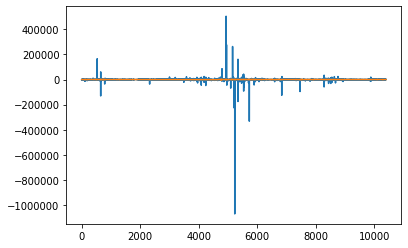

In [25]:
from BundleAdjustment import *
from scipy.optimize import least_squares
camera_params = np.array(camera_params)
camera_indices = np.array(camera_indices)
print(len(points_3d))
point_indices = np.array(range(len(points_3d)))
points_3d = np.array(points_3d)
points_2d = np.array(points_2d)
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))
print(camera_params[0])
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))
#plt.plot(res.fun)
#fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d)

In [26]:
print(res)

 active_mask: array([0., 0., 0., ..., 0., 0., 0.])
        cost: 107436087.9755381
         fun: array([-0.17773667,  0.1822191 , -0.24909232, ...,  0.02183635,
       -0.05768194,  0.01316593])
        grad: array([-1.42642107e+07,  1.94866001e+07, -3.07213138e+06, ...,
       -9.09070855e+01,  3.84050854e-01, -1.38579842e+02])
         jac: <10404x15876 sparse matrix of type '<class 'numpy.float64'>'
	with 124848 stored elements in Compressed Sparse Row format>
     message: '`ftol` termination condition is satisfied.'
        nfev: 163
        njev: 121
  optimality: 2.442774386738056e+19
      status: 2
     success: True
           x: array([ 20.60432813, -27.74422295,   3.98343949, ...,   2.3781971 ,
         1.23298685,  -0.52906671])


In [27]:
camera_params = res.x[:n_cameras * 9].reshape((n_cameras, 9))
points_3d = res.x[n_cameras * 9:].reshape((n_points, 3))

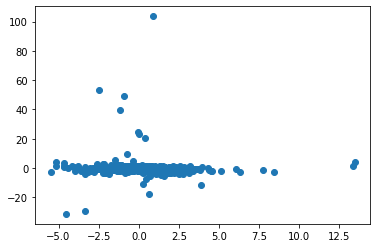

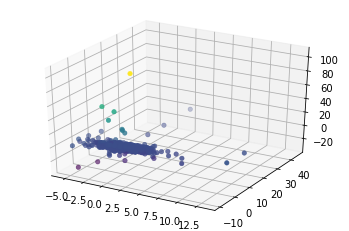

In [28]:
#XZ
plt.scatter(points_3d[:,0], points_3d[:,2])
#plt.scatter(C0[0], C0[2], c='red')
#plt.scatter(C1[0], C1[2], c='black')
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], c=points_3d[:,2], cmap='viridis', linewidth=0.5);
#ax.scatter(C0[0], C0[1], C0[2], c='red', linewidth=15);
#ax.scatter(C1[0], C1[1], C1[2], c='black', linewidth=15);
plt.show()

In [29]:
print(len(points_3d))

5202


In [30]:
print(points_3d[:10])

[[ 0.57837504  0.37055535 -0.51501833]
 [ 0.90165056  0.39112493 -0.53733361]
 [-0.42300099 -0.3565364  -0.19240014]
 [ 0.68220043  0.25780542 -0.4757571 ]
 [ 0.73002378  0.18444103 -0.4630427 ]
 [ 2.22134855  1.24962494 -0.91621431]
 [ 0.06892655 -0.17875548 -0.28830897]
 [ 1.12238034  0.4631036  -0.57767949]
 [ 0.39116574  0.16350139 -0.42487164]
 [-0.57510433 -0.26068658 -0.19896384]]
